# StarFast example notebook
This notebook was used to generate all of the images in DMTN-012 (http://dmtn-012.lsst.io/), and illustrates the basic uses of StarFast.

For these examples, I am using a reference image at close to zenith (airmass 1.00), and an "observed" image taken at airmass 1.2 for simple image differencing (with and without noise). I have not included any attempt at PSF matching, and so the dipoles for most objects are worse. However, this notebook is examining the effect of Differential Chromatic Refraction (DCR) and I want the effects to be unambiguous. Also, note that the dipoles may be in different directions between very hot and very cool stars! In some cases, standard PSF matching might make the dipoles of very hot and rare objects worse.

In the first section, I use star_sim to generate simulated images with 10,000 stars in the LSST u-band from a catalog of type K - type O stars randomly distributed within a conical volume 1000 light years long and ~4 arcmin wide.

In the second section, I simulate just a single star, but as each spectral type and at u and g bands. 


## Load StarFast

You will need to change "starfast_directory" to the location where you downloaded the StarFast code. The code can be obtained from https://github.com/lsst-dm/starfast_simulator

In [1]:
starfast_directory = '/Users/sullivan/LSST/code/StarFast/'
import imp
imp.load_source('fast_dft', starfast_directory + 'fast_dft.py')
imp.load_source('calc_refractive_index', starfast_directory + 'calc_refractive_index.py')
imp.load_source('StarFast', starfast_directory + 'StarFast.py')

<module 'StarFast' from '/Users/sullivan/LSST/code/StarFast/StarFast.pyc'>

In [2]:
%matplotlib inline
import os
import cPickle
import galsim 
from lsst.sims.photUtils import matchStar
import numpy as np
from StarFast import StarSim
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.cm as cm

First, load in model Kurucz SEDs from sims.photUtils

In [3]:
pickle_file = 'sed_list.pickle'
if os.path.exists(pickle_file):
    with open(pickle_file, 'rb') as dumpfile:
        sed_list = cPickle.load(dumpfile)
else:
    %%capture
    matchStarObj = matchStar()
    sed_list = matchStarObj.loadKuruczSEDs()
    with open(pickle_file, 'wb') as dumpfile:
        cPickle.dump(sed_list, dumpfile, cPickle.HIGHEST_PROTOCOL)

Set up the basic parameters that each simulation will use

In [4]:
seed = 5
dimension = 1024 # number of pixels on a side of the simulation
n_star = 10000
pixel_scale = 0.25 # arcsec / pixel
band_name = 'u'  # vaild options are 'u', 'g', 'r', 'i', 'z', or 'y'
hottest_star='O' # vaild options are None (defaults to 'A') or any stellar type OBAFGKM hotter than coolest star
coolest_star='K' # vaild options are None (defaults to 'M') or any stellar type OBAFGKM cooler than hottest star
wavelength_step = 3 # wavelength bin size, in nm
photons_per_adu = 1e4
gsp = galsim.GSParams(folding_threshold=1.0/(dimension), maximum_fft_size=12288)
psf = galsim.Kolmogorov(fwhm=1.0, flux=1, gsparams=gsp)

ref_elevation = 85.0 # in degrees
ref_azimuth = 0.0 # in degrees

obs_elevation = 90.0 - 33.6 # in degrees
obs_azimuth = 20.0 # in degrees

## StarFast simulation setup

First, create the simulation object 'example_sim':

In [5]:
example_sim = StarSim(psf=psf, pixel_scale=pixel_scale, x_size=dimension, y_size=dimension, band_name=band_name,
                      wavelength_step=wavelength_step, sed_list=sed_list)

Load in a catalog of random sources. This catalog will be used for all of the remaining steps, and the same random catalog can be generated in a new session at a later time by specifying the same seed value.

In [6]:
example_sim.load_catalog(n_star=n_star, hottest_star=hottest_star, coolest_star=coolest_star, seed=seed)

Number and flux contribution of stars of each type:
 [M 0| 0.00%] [K 5124| 0.29%] [G 3303| 0.60%] [F 1255| 0.75%] [A 274| 2.11%] [B 44| 96.25%] [O 0| 0.00%]


Build a Fourier-space representation of the sky based on the loaded catalog. This model will be used for all of the remaining steps, including simulating effects with variable PSFs such as DCR.

In [7]:
example_sim.simulate()

Simulating 2542 stars within observable region
Time to model 2531 stars: [24.398s | 0.00964s per star]
Time to model 11 bright stars: [15.341s | 1.39464s per star]


There are fewer than 10,000 stars in the simulation, since StarFast creates a catalog covering an area larger than a single image. This is to allow repeated observations of the same field (by setting the same seed value) under different sky rotation angles or offsets, to simulate real observations.

## StarFast simulation without noise

StarFast images are created after the simulated model is convolved with a PSF. The models are constructed with multiple image planes with restricted wavelength ranges, so each plane can be convolved with a different PSF and stacked. The only significant computations at this point are the FFTs, so the timing does not depend on the complexity of the source model.

In [8]:
ref_exposure = example_sim.convolve(elevation=ref_elevation, azimuth=ref_azimuth)
obs_exposure = example_sim.convolve(elevation=obs_elevation, azimuth=obs_azimuth)

FFT timing for 24 DCR planes: [6.316s | 0.263s per plane]
FFT timing for 24 DCR planes: [26.030s | 1.085s per plane]
FFT timing for 24 DCR planes: [5.899s | 0.246s per plane]
FFT timing for 24 DCR planes: [23.992s | 1.000s per plane]


StarFast creates images that are LSST exposures. To extract only the image, use:

In [9]:
ref_image = ref_exposure.getMaskedImage().getImage().getArray()
obs_image = obs_exposure.getMaskedImage().getImage().getArray()

LSST exposures have a writeFits method for persisting data. These fits files can be viewed in ds9 or processed with the LSST stack (starting with "ingestSimImages.py images images/*.fits --mode link --output input_data")

In [ ]:
ref_exposure.writeFits("/Users/sullivan/LSST/simulations/test2/images/lsst_e_100_f2_R22_S11_E000.fits")
obs_exposure.writeFits("/Users/sullivan/LSST/simulations/test2/images/lsst_e_101_f2_R22_S11_E000.fits")

## StarFast simulation with added noise

In [10]:
sky_noise = 0.001
ref_exposure_addnoise=example_sim.convolve(elevation=ref_elevation, azimuth=ref_azimuth, sky_noise=sky_noise)
obs_exposure_addnoise=example_sim.convolve(elevation=obs_elevation, azimuth=obs_azimuth, sky_noise=sky_noise)

Adding sky noise with amplitude 0.001000
FFT timing for 24 DCR planes: [9.013s | 0.376s per plane]
FFT timing for 24 DCR planes: [24.127s | 1.005s per plane]
Adding sky noise with amplitude 0.001000
FFT timing for 24 DCR planes: [8.812s | 0.367s per plane]
FFT timing for 24 DCR planes: [24.313s | 1.013s per plane]


In [11]:
ref_image_addnoise = ref_exposure_addnoise.getMaskedImage().getImage().getArray()
obs_image_addnoise = obs_exposure_addnoise.getMaskedImage().getImage().getArray()

## Make a few comparison plots

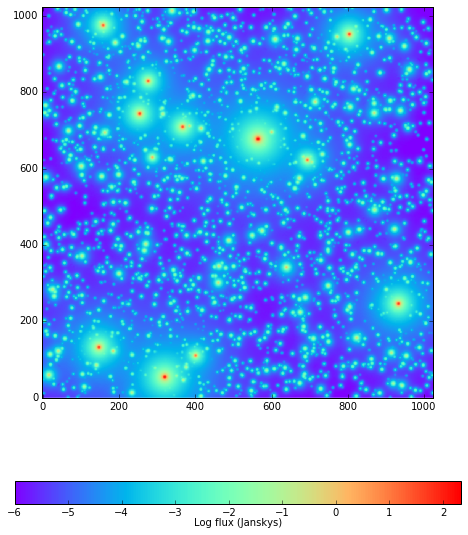

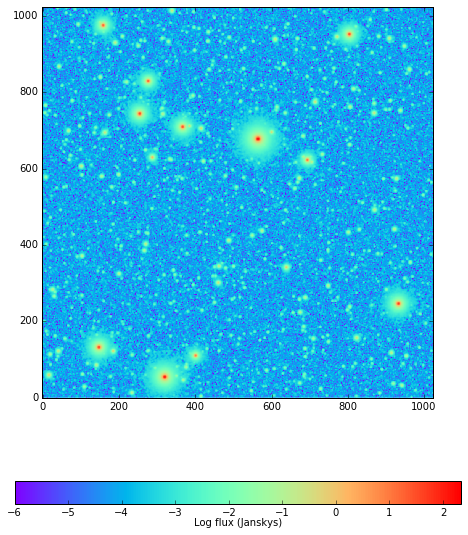

In [12]:
fig = plt.figure(figsize=(10, 10), dpi=300)
fig_show = plt.imshow(np.clip(np.log10(np.abs(ref_image)),-6, np.Inf), interpolation='none', origin='lower', cmap=cm.rainbow)
cbar=plt.colorbar(fig_show, orientation='horizontal', shrink=.8)
cbar.set_label('Log flux (Janskys)', labelpad=0, rotation=0)
plt.savefig('ref_img10000_log.png',bbox_inches='tight', dpi=300)

fig = plt.figure(figsize=(10, 10), dpi=300)
fig_show = plt.imshow(np.clip(np.log10(np.abs(ref_image_addnoise)),-6, np.Inf), interpolation='none', origin='lower', cmap=cm.rainbow)
cbar=plt.colorbar(fig_show, orientation='horizontal', shrink=.8)
cbar.set_label('Log flux (Janskys)', labelpad=0, rotation=0)
plt.savefig('ref_img10000_log_addnoise.png',bbox_inches='tight', dpi=300)

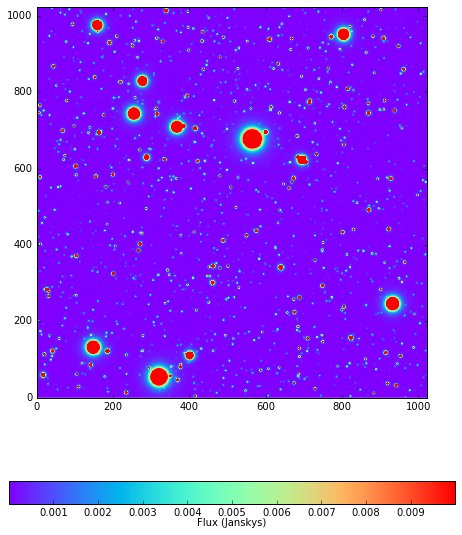

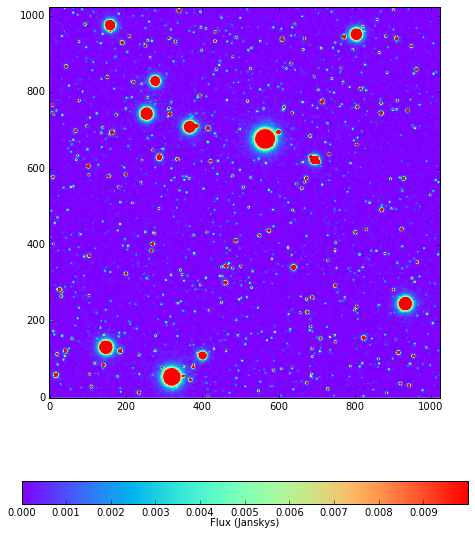

In [13]:
fig = plt.figure(figsize=(10,10), dpi=300)
fig_show = plt.imshow(np.clip(ref_image,0,0.01), interpolation='none', origin='lower', cmap=cm.rainbow)
cbar=plt.colorbar(fig_show, orientation='horizontal', shrink=.8)
cbar.set_label('Flux (Janskys)', labelpad=0, rotation=0)
plt.savefig('ref_img10000_linear.png',bbox_inches='tight', dpi=300)

fig = plt.figure(figsize=(10,10), dpi=300)
fig_show = plt.imshow(np.clip(ref_image_addnoise,0,0.01), interpolation='none', origin='lower', cmap=cm.rainbow)
cbar=plt.colorbar(fig_show, orientation='horizontal', shrink=.8)
cbar.set_label('Flux (Janskys)', labelpad=0, rotation=0)
plt.savefig('ref_img10000_linear_addnoise.png',bbox_inches='tight', dpi=300)

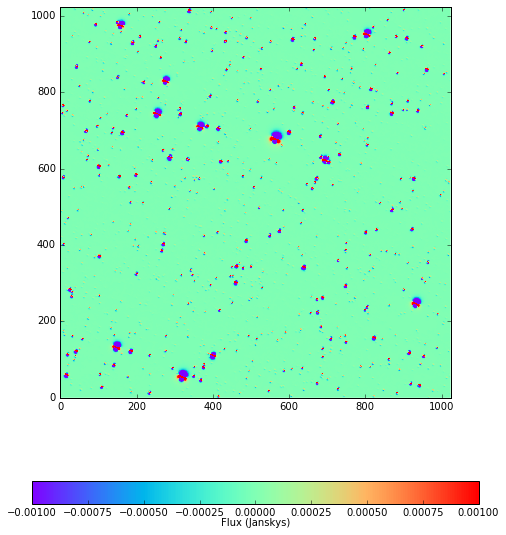

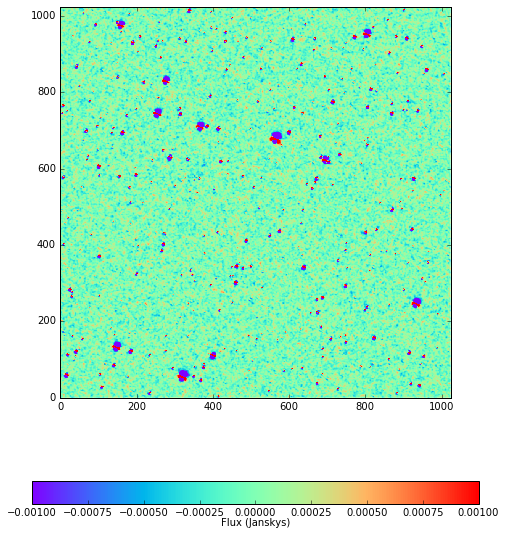

In [14]:
fig = plt.figure(figsize=(10,10), dpi=300)
dcr_color_scale=1e-3
fig_show = plt.imshow(np.clip(ref_image-obs_image,-dcr_color_scale, dcr_color_scale), 
                      interpolation='none', origin='lower', cmap=cm.rainbow)
cbar=plt.colorbar(fig_show, orientation='horizontal', shrink=.8)
cbar.set_label('Flux (Janskys)', labelpad=0, rotation=0)
plt.savefig('dcr_img10000_linear.png',bbox_inches='tight', dpi=300)

fig = plt.figure(figsize=(10,10), dpi=300)
fig_show = plt.imshow(np.clip(ref_image_addnoise-obs_image_addnoise,-dcr_color_scale, dcr_color_scale),
                      interpolation='none', origin='lower', cmap=cm.rainbow)
cbar=plt.colorbar(fig_show, orientation='horizontal', shrink=.8)
cbar.set_label('Flux (Janskys)', labelpad=0, rotation=0)
plt.savefig('dcr_img10000_linear_addnoise.png',bbox_inches='tight', dpi=300)

# Explore the effect of DCR on single stars

In [15]:
seed = 5
dimension = 64 # number of pixels on a side of the simulation
pixel_scale = 0.25 # arcsec / pixel
n_star = 1
wavelength_step = 3 # wavelength bin size, in nm
verbose = False

In [16]:
def look(img, range=None, x_range=None, y_range=None):
    """Simple function to wrap matplotlib and display an image with a colorbar."""
    plt.figure(figsize=(8, 6))
    if range is None:
        range = [np.min(img), np.max(img)]
    img_use = np.clip(img, range[0], range[1])
    if x_range is not None:
        x0 = int(x_range[0])
        x1 = int(x_range[1])
        if x0 < 0:
            img_use = np.roll(img_use, -x0, axis=1)
            x1 -= x0
            x0 = 0
        img_use = img_use[:, x0: x1]
    if y_range is not None:
        y0 = int(y_range[0])
        y1 = int(y_range[1])
        if y0 < 0:
            img_use = np.roll(img_use, -y0, axis=0)
            y1 -= y0
            y0 = 0
        img_use = img_use[y0: y1, :]
    fig_show = plt.imshow(img_use, interpolation='none', origin='lower', cmap=cm.rainbow)
    plt.colorbar(fig_show, orientation='vertical', shrink=1)
#    cbar.set_label('DCR (arcsec)', labelpad=0)
    plt.show()

## u band

Number and flux contribution of stars of each type:
 [M 0| 0.00%] [K 0| 0.00%] [G 0| 0.00%] [F 0| 0.00%] [A 0| 0.00%] [B 0| 0.00%] [O 1| 100.00%]
Simulating 1 stars within observable region
Time to model 1 bright star: [0.029s]
FFT timing for 24 DCR planes: [0.089s | 0.004s per plane]
FFT timing for 24 DCR planes: [0.088s | 0.004s per plane]


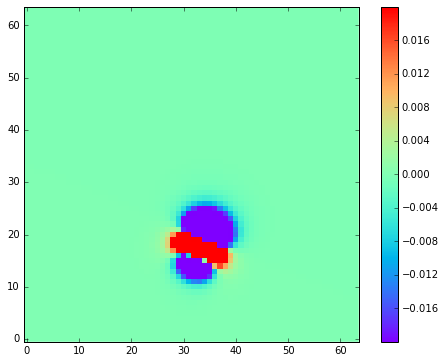

In [17]:
band_name = 'u'  # vaild options are 'u', 'g', 'r', 'i', 'z', or 'y'
hottest_star='O' # vaild options are None (defaults to 'A') or any stellar type OBAFGKM hotter than coolest star
coolest_star='O' # vaild options are None (defaults to 'M') or any stellar type OBAFGKM cooler than hottest star

sim_u_band = StarSim(psf=psf, pixel_scale=pixel_scale, x_size=dimension, y_size=dimension, band_name=band_name,
                      wavelength_step=wavelength_step, sed_list=sed_list)
sim_u_band.load_catalog(n_star=n_star, hottest_star=hottest_star, coolest_star=coolest_star, seed=seed)
sim_u_band.simulate()
ref_image_u_O = sim_u_band.convolve(elevation=ref_elevation, azimuth=ref_azimuth).getMaskedImage().getImage().getArray()
obs_image_u_O = sim_u_band.convolve(elevation=obs_elevation, azimuth=obs_azimuth).getMaskedImage().getImage().getArray()

look(ref_image_u_O - obs_image_u_O, range=[-0.02, 0.02])

Number and flux contribution of stars of each type:
 [M 0| 0.00%] [K 0| 0.00%] [G 0| 0.00%] [F 0| 0.00%] [A 0| 0.00%] [B 1| 100.00%] [O 0| 0.00%]
Simulating 1 stars within observable region
Time to model 1 bright star: [0.039s]
FFT timing for 24 DCR planes: [0.121s | 0.005s per plane]
FFT timing for 24 DCR planes: [0.096s | 0.004s per plane]


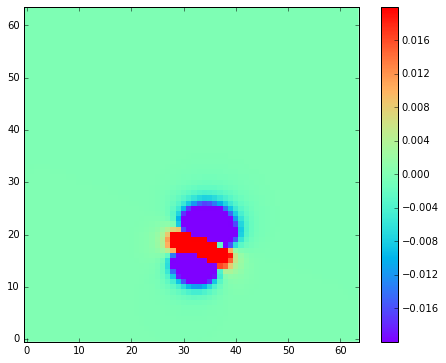

In [18]:
hottest_star='B' # vaild options are None (defaults to 'A') or any stellar type OBAFGKM hotter than coolest star
coolest_star='B' # vaild options are None (defaults to 'M') or any stellar type OBAFGKM cooler than hottest star

sim_u_band.load_catalog(n_star=n_star, hottest_star=hottest_star, coolest_star=coolest_star, seed=seed)
sim_u_band.simulate()
ref_image_u_B = sim_u_band.convolve(elevation=ref_elevation, azimuth=ref_azimuth).getMaskedImage().getImage().getArray()
obs_image_u_B = sim_u_band.convolve(elevation=obs_elevation, azimuth=obs_azimuth).getMaskedImage().getImage().getArray()

look(ref_image_u_B - obs_image_u_B, range=[-0.02, 0.02])

Number and flux contribution of stars of each type:
 [M 0| 0.00%] [K 0| 0.00%] [G 0| 0.00%] [F 0| 0.00%] [A 1| 100.00%] [B 0| 0.00%] [O 0| 0.00%]
Simulating 1 stars within observable region
Time to model 1 bright star: [0.032s]
FFT timing for 24 DCR planes: [0.087s | 0.004s per plane]
FFT timing for 24 DCR planes: [0.086s | 0.004s per plane]


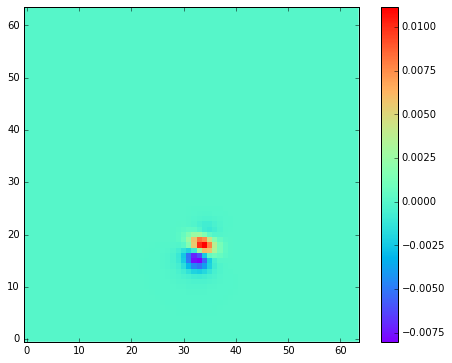

In [19]:
hottest_star='A' # vaild options are None (defaults to 'A') or any stellar type OBAFGKM hotter than coolest star
coolest_star='A' # vaild options are None (defaults to 'M') or any stellar type OBAFGKM cooler than hottest star

sim_u_band.load_catalog(n_star=n_star, hottest_star=hottest_star, coolest_star=coolest_star, seed=seed)
sim_u_band.simulate()
ref_image_u_A = sim_u_band.convolve(elevation=ref_elevation, azimuth=ref_azimuth).getMaskedImage().getImage().getArray()
obs_image_u_A = sim_u_band.convolve(elevation=obs_elevation, azimuth=obs_azimuth).getMaskedImage().getImage().getArray()

look(ref_image_u_A - obs_image_u_A, range=[-0.02, 0.02])

Number and flux contribution of stars of each type:
 [M 0| 0.00%] [K 0| 0.00%] [G 0| 0.00%] [F 1| 100.00%] [A 0| 0.00%] [B 0| 0.00%] [O 0| 0.00%]
Simulating 1 stars within observable region
Time to model 1 bright star: [0.031s]
FFT timing for 24 DCR planes: [0.086s | 0.004s per plane]
FFT timing for 24 DCR planes: [0.088s | 0.004s per plane]


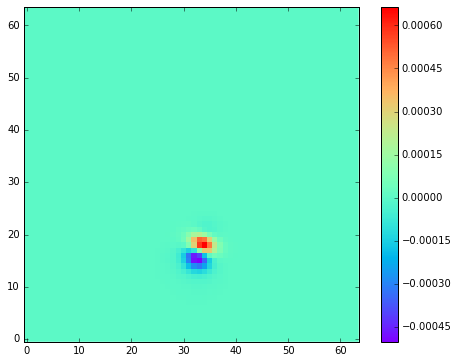

In [20]:
hottest_star='F' # vaild options are None (defaults to 'A') or any stellar type OBAFGKM hotter than coolest star
coolest_star='F' # vaild options are None (defaults to 'M') or any stellar type OBAFGKM cooler than hottest star

sim_u_band.load_catalog(n_star=n_star, hottest_star=hottest_star, coolest_star=coolest_star, seed=seed)
sim_u_band.simulate()
ref_image_u_F = sim_u_band.convolve(elevation=ref_elevation, azimuth=ref_azimuth).getMaskedImage().getImage().getArray()
obs_image_u_F = sim_u_band.convolve(elevation=obs_elevation, azimuth=obs_azimuth).getMaskedImage().getImage().getArray()

look(ref_image_u_F - obs_image_u_F, range=[-0.02, 0.02])

Number and flux contribution of stars of each type:
 [M 0| 0.00%] [K 0| 0.00%] [G 1| 100.00%] [F 0| 0.00%] [A 0| 0.00%] [B 0| 0.00%] [O 0| 0.00%]
Simulating 1 stars within observable region
Time to model 1 bright star: [0.036s]
FFT timing for 24 DCR planes: [0.130s | 0.005s per plane]
FFT timing for 24 DCR planes: [0.131s | 0.005s per plane]


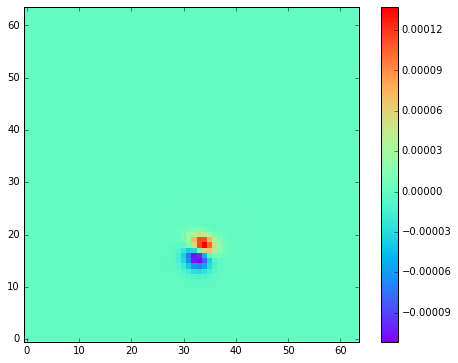

In [21]:
hottest_star='G' # vaild options are None (defaults to 'A') or any stellar type OBAFGKM hotter than coolest star
coolest_star='G' # vaild options are None (defaults to 'M') or any stellar type OBAFGKM cooler than hottest star

sim_u_band.load_catalog(n_star=n_star, hottest_star=hottest_star, coolest_star=coolest_star, seed=seed)
sim_u_band.simulate()
ref_image_u_G = sim_u_band.convolve(elevation=ref_elevation, azimuth=ref_azimuth).getMaskedImage().getImage().getArray()
obs_image_u_G = sim_u_band.convolve(elevation=obs_elevation, azimuth=obs_azimuth).getMaskedImage().getImage().getArray()

look(ref_image_u_G - obs_image_u_G, range=[-0.02, 0.02])

Number and flux contribution of stars of each type:
 [M 0| 0.00%] [K 1| 100.00%] [G 0| 0.00%] [F 0| 0.00%] [A 0| 0.00%] [B 0| 0.00%] [O 0| 0.00%]
Simulating 1 stars within observable region
Time to model 1 bright star: [0.039s]
FFT timing for 24 DCR planes: [0.136s | 0.006s per plane]
FFT timing for 24 DCR planes: [0.121s | 0.005s per plane]


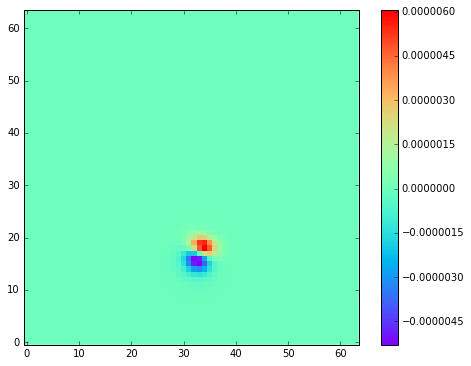

In [22]:
hottest_star='K' # vaild options are None (defaults to 'A') or any stellar type OBAFGKM hotter than coolest star
coolest_star='K' # vaild options are None (defaults to 'M') or any stellar type OBAFGKM cooler than hottest star

sim_u_band.load_catalog(n_star=n_star, hottest_star=hottest_star, coolest_star=coolest_star, seed=seed)
sim_u_band.simulate()
ref_image_u_K = sim_u_band.convolve(elevation=ref_elevation, azimuth=ref_azimuth).getMaskedImage().getImage().getArray()
obs_image_u_K = sim_u_band.convolve(elevation=obs_elevation, azimuth=obs_azimuth).getMaskedImage().getImage().getArray()

look(ref_image_u_K - obs_image_u_K, range=[-0.02, 0.02])

# g band

In [23]:
band_name = 'g'  # vaild options are 'u', 'g', 'r', 'i', 'z', or 'y'
sim_g_band = StarSim(psf=psf, pixel_scale=pixel_scale, x_size=dimension, y_size=dimension, band_name=band_name,
                      wavelength_step=wavelength_step, sed_list=sed_list)

Number and flux contribution of stars of each type:
 [M 0| 0.00%] [K 0| 0.00%] [G 0| 0.00%] [F 0| 0.00%] [A 0| 0.00%] [B 0| 0.00%] [O 1| 100.00%]
Simulating 1 stars within observable region
Time to model 1 bright star: [0.058s]
FFT timing for 49 DCR planes: [0.185s | 0.004s per plane]
FFT timing for 49 DCR planes: [0.180s | 0.004s per plane]


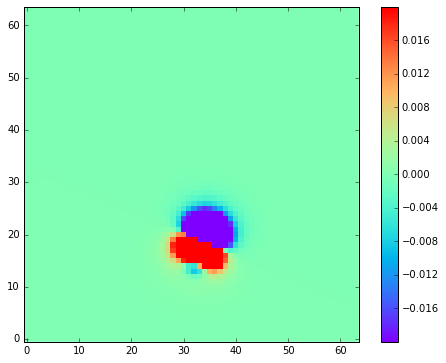

In [24]:
hottest_star='O' # vaild options are None (defaults to 'A') or any stellar type OBAFGKM hotter than coolest star
coolest_star='O' # vaild options are None (defaults to 'M') or any stellar type OBAFGKM cooler than hottest star

sim_g_band.load_catalog(n_star=n_star, hottest_star=hottest_star, coolest_star=coolest_star, seed=seed)
sim_g_band.simulate()

ref_image_g_O = sim_g_band.convolve(elevation=ref_elevation, azimuth=ref_azimuth).getMaskedImage().getImage().getArray()
obs_image_g_O = sim_g_band.convolve(elevation=obs_elevation, azimuth=obs_azimuth).getMaskedImage().getImage().getArray()

look(ref_image_g_O - obs_image_g_O, range=[-0.02, 0.02])

Number and flux contribution of stars of each type:
 [M 0| 0.00%] [K 0| 0.00%] [G 0| 0.00%] [F 0| 0.00%] [A 0| 0.00%] [B 1| 100.00%] [O 0| 0.00%]
Simulating 1 stars within observable region
Time to model 1 bright star: [0.063s]
FFT timing for 49 DCR planes: [0.174s | 0.004s per plane]
FFT timing for 49 DCR planes: [0.164s | 0.003s per plane]


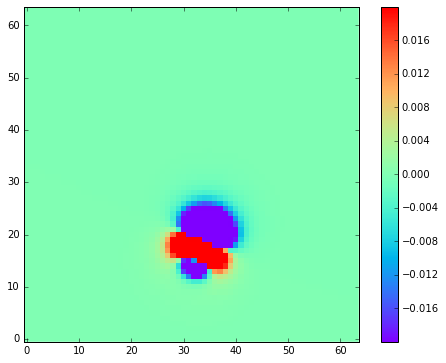

In [25]:
hottest_star='B' # vaild options are None (defaults to 'A') or any stellar type OBAFGKM hotter than coolest star
coolest_star='B' # vaild options are None (defaults to 'M') or any stellar type OBAFGKM cooler than hottest star

sim_g_band.load_catalog(n_star=n_star, hottest_star=hottest_star, coolest_star=coolest_star, seed=seed)
sim_g_band.simulate()

ref_image_g_B = sim_g_band.convolve(elevation=ref_elevation, azimuth=ref_azimuth).getMaskedImage().getImage().getArray()
obs_image_g_B = sim_g_band.convolve(elevation=obs_elevation, azimuth=obs_azimuth).getMaskedImage().getImage().getArray()

look(ref_image_g_B - obs_image_g_B, range=[-0.02, 0.02])

Number and flux contribution of stars of each type:
 [M 0| 0.00%] [K 0| 0.00%] [G 0| 0.00%] [F 0| 0.00%] [A 1| 100.00%] [B 0| 0.00%] [O 0| 0.00%]
Simulating 1 stars within observable region
Time to model 1 bright star: [0.058s]
FFT timing for 49 DCR planes: [0.173s | 0.004s per plane]
FFT timing for 49 DCR planes: [0.167s | 0.003s per plane]


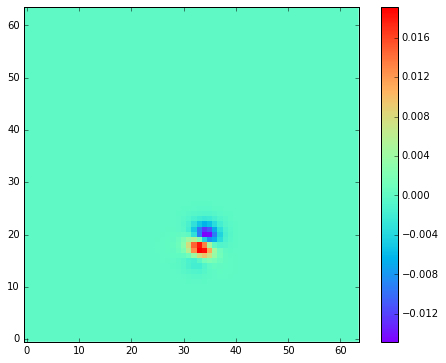

In [26]:
hottest_star='A' # vaild options are None (defaults to 'A') or any stellar type OBAFGKM hotter than coolest star
coolest_star='A' # vaild options are None (defaults to 'M') or any stellar type OBAFGKM cooler than hottest star

sim_g_band.load_catalog(n_star=n_star, hottest_star=hottest_star, coolest_star=coolest_star, seed=seed)
sim_g_band.simulate()

ref_image_g_A = sim_g_band.convolve(elevation=ref_elevation, azimuth=ref_azimuth).getMaskedImage().getImage().getArray()
obs_image_g_A = sim_g_band.convolve(elevation=obs_elevation, azimuth=obs_azimuth).getMaskedImage().getImage().getArray()

look(ref_image_g_A - obs_image_g_A, range=[-0.02, 0.02])

Number and flux contribution of stars of each type:
 [M 0| 0.00%] [K 0| 0.00%] [G 0| 0.00%] [F 1| 100.00%] [A 0| 0.00%] [B 0| 0.00%] [O 0| 0.00%]
Simulating 1 stars within observable region
Time to model 1 bright star: [0.063s]
FFT timing for 49 DCR planes: [0.171s | 0.003s per plane]
FFT timing for 49 DCR planes: [0.165s | 0.003s per plane]


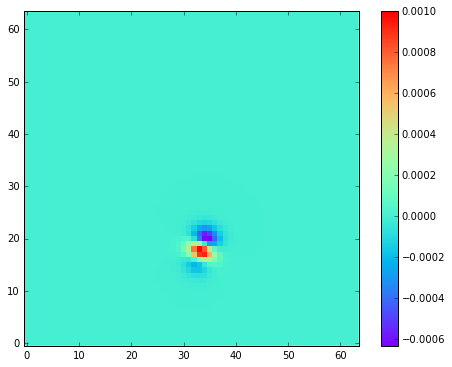

In [27]:
hottest_star='F' # vaild options are None (defaults to 'A') or any stellar type OBAFGKM hotter than coolest star
coolest_star='F' # vaild options are None (defaults to 'M') or any stellar type OBAFGKM cooler than hottest star

sim_g_band.load_catalog(n_star=n_star, hottest_star=hottest_star, coolest_star=coolest_star, seed=seed)
sim_g_band.simulate()

ref_image_g_F = sim_g_band.convolve(elevation=ref_elevation, azimuth=ref_azimuth).getMaskedImage().getImage().getArray()
obs_image_g_F = sim_g_band.convolve(elevation=obs_elevation, azimuth=obs_azimuth).getMaskedImage().getImage().getArray()

look(ref_image_g_F - obs_image_g_F, range=[-0.02, 0.02])

Number and flux contribution of stars of each type:
 [M 0| 0.00%] [K 0| 0.00%] [G 1| 100.00%] [F 0| 0.00%] [A 0| 0.00%] [B 0| 0.00%] [O 0| 0.00%]
Simulating 1 stars within observable region
Time to model 1 bright star: [0.055s]
FFT timing for 49 DCR planes: [0.169s | 0.003s per plane]
FFT timing for 49 DCR planes: [0.174s | 0.004s per plane]


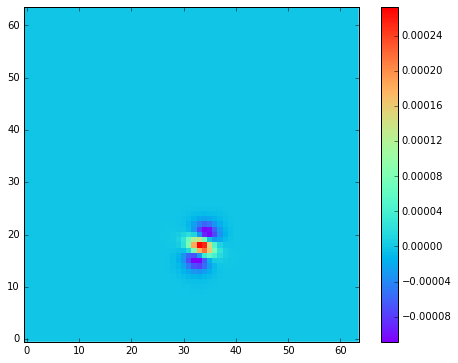

In [28]:
hottest_star='G' # vaild options are None (defaults to 'A') or any stellar type OBAFGKM hotter than coolest star
coolest_star='G' # vaild options are None (defaults to 'M') or any stellar type OBAFGKM cooler than hottest star

sim_g_band.load_catalog(n_star=n_star, hottest_star=hottest_star, coolest_star=coolest_star, seed=seed)
sim_g_band.simulate()

ref_image_g_G = sim_g_band.convolve(elevation=ref_elevation, azimuth=ref_azimuth).getMaskedImage().getImage().getArray()
obs_image_g_G = sim_g_band.convolve(elevation=obs_elevation, azimuth=obs_azimuth).getMaskedImage().getImage().getArray()

look(ref_image_g_G - obs_image_g_G, range=[-0.02, 0.02])

Number and flux contribution of stars of each type:
 [M 0| 0.00%] [K 1| 100.00%] [G 0| 0.00%] [F 0| 0.00%] [A 0| 0.00%] [B 0| 0.00%] [O 0| 0.00%]
Simulating 1 stars within observable region
Time to model 1 bright star: [0.056s]
FFT timing for 49 DCR planes: [0.176s | 0.004s per plane]
FFT timing for 49 DCR planes: [0.170s | 0.003s per plane]


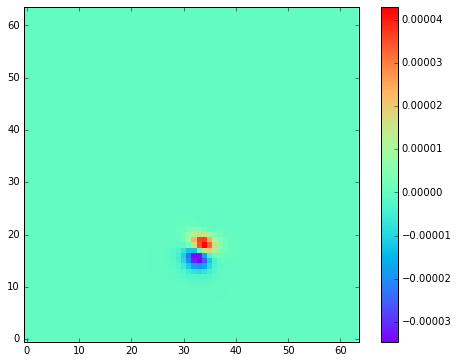

In [29]:
hottest_star='K' # vaild options are None (defaults to 'A') or any stellar type OBAFGKM hotter than coolest star
coolest_star='K' # vaild options are None (defaults to 'M') or any stellar type OBAFGKM cooler than hottest star

sim_g_band.load_catalog(n_star=n_star, hottest_star=hottest_star, coolest_star=coolest_star, seed=seed)
sim_g_band.simulate()

ref_image_g_K = sim_g_band.convolve(elevation=ref_elevation, azimuth=ref_azimuth).getMaskedImage().getImage().getArray()
obs_image_g_K = sim_g_band.convolve(elevation=obs_elevation, azimuth=obs_azimuth).getMaskedImage().getImage().getArray()

look(ref_image_g_K - obs_image_g_K, range=[-0.02, 0.02])